In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Reading in proxy statements for Walmart from 2010 through 2019, reading each page of each PDF document as a separate row in the dataframe.

In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Walmart/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Walmart"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(976, 3)

In [5]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x)
                                                   if word not in stop_words and word not in punctuations])

In [7]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])

In [34]:
remove_words =['shareholders™','walmart','board','mr.','ms.','director','walton','committee','proxy','meeting','share',
               'vote','shareholder','plan','inc.','http','stock','performance']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [35]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [36]:
walmart_df = df[['year','company','tokens_final']]

walmart_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\walmart.csv', 
                 index = False)

In [37]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [38]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [39]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.046*"unit" + 0.041*"award" + 0.036*"grant" + 0.035*"value" + '
        '0.028*"column" + 0.028*"date" + 0.025*"amount" + 0.020*"incentive" + '
        '0.019*"number" + 0.018*"base"'),
    (   1,
        '0.024*"serve" + 0.024*"experience" + 0.024*"chairman" + '
        '0.024*"management" + 0.024*"member" + 0.018*"leadership" + '
        '0.017*"governance" + 0.017*"risk" + 0.016*"business" + 0.011*"role"'),
    (   2,
        '0.025*"amount" + 0.020*"receive" + 0.020*"officer" + 0.017*"benefit" '
        '+ 0.015*"payment" + 0.014*"transaction" + 0.014*"contribution" + '
        '0.013*"include" + 0.012*"bray" + 0.012*"continue"'),
    (   3,
        '0.094*"audit" + 0.032*"accountant" + 0.031*"service" + 0.023*"policy" '
        '+ 0.022*"review" + 0.021*"management" + 0.019*"report" + '
        '0.015*"member" + 0.013*"compliance" + 0.013*"category"'),
    (   4,
        '0.058*"corporation" + 0.036*"group" + 0.031*"proposal" + 0.025*"peer" '
        '+ 0.017*

In [40]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [41]:
# pyLDAvis.show(vis)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.181795 -0.110808       1        1  12.889278
11     0.123284 -0.159415       2        1  10.803314
12     0.053731 -0.044393       3        1   9.095374
0      0.265214 -0.043184       4        1   9.057793
10    -0.069736  0.147413       5        1   7.999622
5     -0.057630 -0.126101       6        1   7.784972
14    -0.074565  0.036975       7        1   7.501987
8      0.188228  0.031022       8        1   7.330807
6      0.069493  0.106624       9        1   6.449314
7     -0.219472 -0.058819      10        1   5.873630
3     -0.123177 -0.024581      11        1   5.677440
2      0.084307  0.019475      12        1   3.156094
13    -0.071702  0.252164      13        1   2.241263
9      0.094536  0.024202      14        1   2.147737
4     -0.080719 -0.050573      15        1   1.991370, topic_info=               Term         Freq        Total Category  logprob  loglift
89            audit  1216.000000  1216.000000  Default  30.0000  30.0000
57         proposal  1029.000000  1029.000000  Default  29.0000  29.0000
683            unit  1006.000000  1006.000000  Default  28.0000  28.0000
611          amount  1236.000000  1236.000000  Default  27.0000  27.0000
961            sale  1045.000000  1045.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
344         believe    21.405701   537.765015  Topic15  -4.9651   0.6926
593       recommend    18.048540   224.325012  Topic15  -5.1357   1.3963
152         holding    15.914280   129.971008  Topic15  -5.2616   1.8163
553  responsibility    15.186980   394.724518  Topic15  -5.3084   0.6586
18          contain    14.626655   132.335434  Topic15  -5.3460   1.7139

[1031 rows x 6 columns], token_table=      Topic      Freq                                Term
term                                                     
2246      5  0.829110  //stock.walmart.com/annual-reports
2246     10  0.103639  //stock.walmart.com/annual-reports
708       2  0.127260                        above-market
708       4  0.636301                        above-market
708       7  0.127260                        above-market
...     ...       ...                                 ...
1267      3  0.026646                               yield
1267      4  0.639501                               yield
1267      7  0.026646                               yield
1267      8  0.213167                               yield
1267     13  0.026646                               yield

[4856 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 13, 1, 11, 6, 15, 9, 7, 8, 4, 3, 14, 10, 5])

In [42]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [43]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[street, website, www.walmartstores.com, notic...",10.0,0.9932,"material, receive, instruction, hold, name, re..."
1,NaN,NaN,10.0,0.5666,"material, receive, instruction, hold, name, re..."
2,2010,"[wal-mart, store, street, website, www.walmart...",8.0,0.4040,"defer, amount, contribution, incentive, accoun..."
3,2010,"[nonqualified, compensation, potential, paymen...",10.0,0.9136,"material, receive, instruction, hold, name, re..."
4,2010,"[compensation, store, compensation, amend, jan...",13.0,0.9948,"proposal, election, majority, nominee, holder,..."
5,2010,"[election, nominee, name, statement, company, ...",10.0,0.8997,"material, receive, instruction, hold, name, re..."
6,2010,"[effect, broker, proposal, broker, occur, regi...",10.0,0.9963,"material, receive, instruction, hold, name, re..."
7,2010,"[revoke, revoke, record, holder, filing, write...",7.0,0.5096,"experience, business, candidate, process, skil..."
8,2010,"[owner, hold, street, name, describe, bank, br...",1.0,0.9965,"serve, experience, chairman, management, membe..."
9,2010,"[michele, burn, burn, chairman, mercer, subsid...",1.0,0.9955,"serve, experience, chairman, management, membe..."


In [44]:
df_dominant_topic.shape

(976, 5)

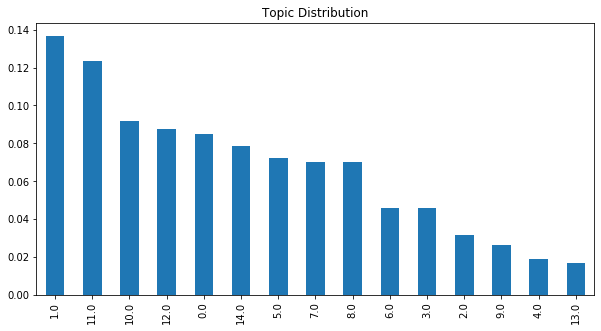

In [45]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [46]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [47]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.094737,0.063158,0.031579,0.031579,0.010526,0.063158,0.231579,0.042105,0.126316,0.031579,0.052632,0.063158,0.084211,0.010526,0.063158
2011,0.138462,0.092308,0.046154,0.076923,0.030769,0.076923,0.000000,0.046154,0.061538,0.030769,0.092308,0.092308,0.107692,0.015385,0.092308
2012,0.104478,0.119403,0.044776,0.029851,0.029851,0.104478,0.000000,0.059701,0.059701,0.044776,0.089552,0.134328,0.059701,0.014925,0.104478
2013,0.076923,0.166667,0.012821,0.051282,0.012821,0.038462,0.025641,0.038462,0.089744,0.038462,0.102564,0.102564,0.141026,0.025641,0.076923
2014,0.096774,0.182796,0.032258,0.032258,0.021505,0.043011,0.000000,0.053763,0.053763,0.032258,0.107527,0.118280,0.107527,0.010753,0.107527
2015,0.067227,0.142857,0.033613,0.025210,0.008403,0.067227,0.134454,0.067227,0.067227,0.025210,0.109244,0.134454,0.050420,0.008403,0.058824
2016,0.084112,0.149533,0.028037,0.056075,0.018692,0.056075,0.028037,0.065421,0.112150,0.018692,0.093458,0.121495,0.084112,0.018692,0.065421
2017,0.070175,0.157895,0.026316,0.061404,0.017544,0.087719,0.000000,0.096491,0.043860,0.017544,0.096491,0.149123,0.061404,0.026316,0.087719
2018,0.083333,0.138889,0.027778,0.055556,0.027778,0.092593,0.000000,0.101852,0.046296,0.018519,0.074074,0.157407,0.101852,0.009259,0.064815


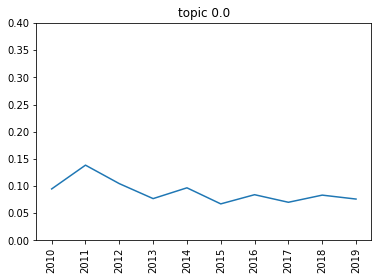

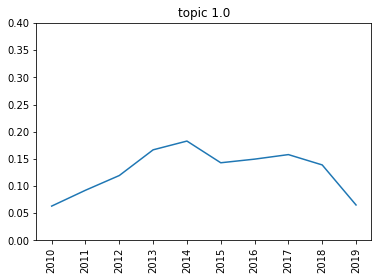

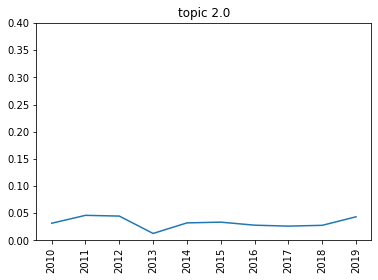

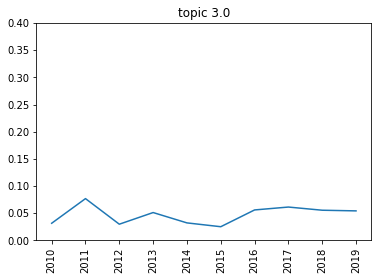

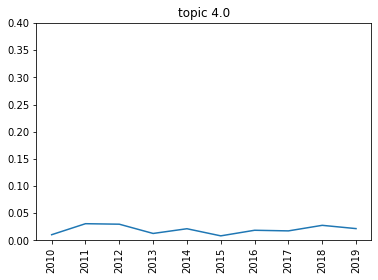

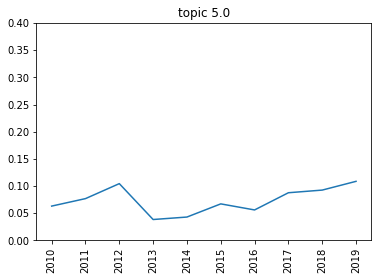

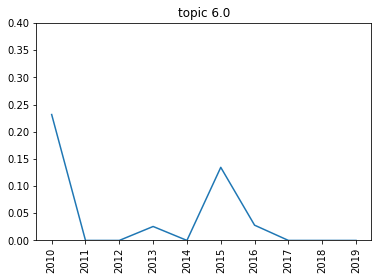

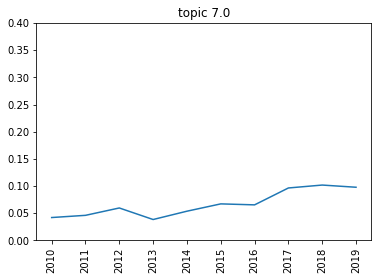

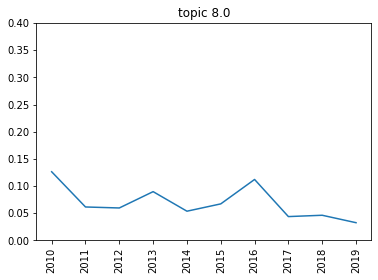

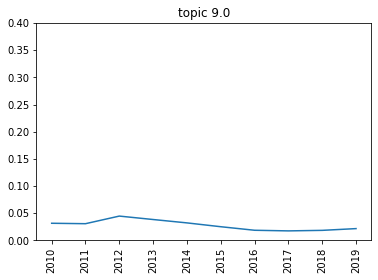

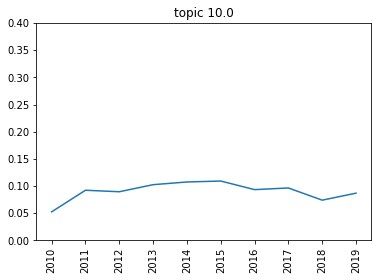

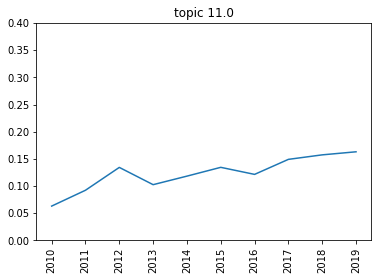

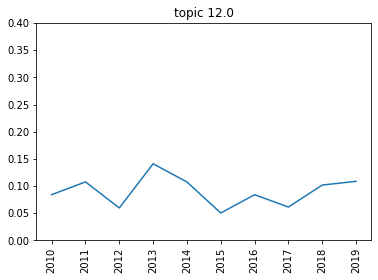

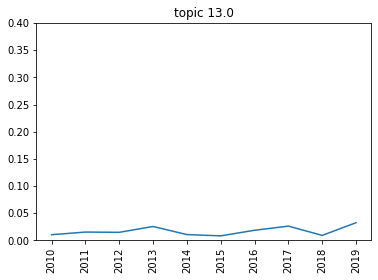

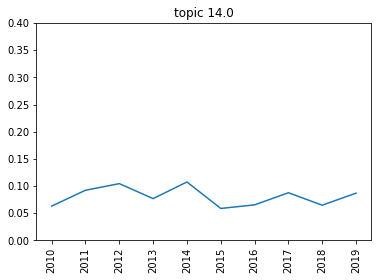

In [48]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

### Checking for correlation with CPI 

Data is Consumer Price Index for all items less medical care in the US

In [49]:
df_cpi = pd.read_csv('CPI.csv')
df_cpi.columns = ['date','cpi']

In [50]:
df_trend = df_trend.reset_index()
df_trend_new = df_trend.drop('year', axis=1)

In [51]:
df_trend_new.corrwith(df_cpi['cpi'])

topic
0.0     0.655006
1.0    -0.255575
2.0     0.306799
3.0     0.673843
4.0     0.790969
5.0     0.390601
6.0    -0.494854
7.0     0.127805
8.0    -0.344444
9.0     0.044297
10.0   -0.326545
11.0   -0.018593
12.0    0.335656
13.0    0.135132
14.0    0.460779
dtype: float64

### Checking for correlation with Labor Force Statistics/Unemployment Rate

In [52]:
labor = pd.read_excel('LaborForceStats.xlsx')

In [53]:
labor['avg'] = labor[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].mean(axis=1)
labor

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg
0,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3,9.608333
1,2011,9.1,9.0,9.0,9.1,9.0,9.1,9.0,9.0,9.0,8.8,8.6,8.5,8.933333
2,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9,8.075000
3,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7,7.358333
4,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6,6.158333
5,2015,5.7,5.5,5.4,5.4,5.6,5.3,5.2,5.1,5.0,5.0,5.1,5.0,5.275000
6,2016,4.9,4.9,5.0,5.0,4.8,4.9,4.8,4.9,5.0,4.9,4.7,4.7,4.875000
7,2017,4.7,4.6,4.4,4.4,4.4,4.3,4.3,4.4,4.2,4.1,4.2,4.1,4.341667
8,2018,4.1,4.1,4.0,4.0,3.8,4.0,3.8,3.8,3.7,3.8,3.7,3.9,3.891667
9,2019,4.0,3.8,3.8,3.6,3.6,3.7,3.7,3.7,3.5,3.6,3.5,3.5,3.666667


In [54]:
df_trend_new.corrwith(labor['avg'])

topic
0.0     0.679373
1.0    -0.316385
2.0     0.172008
3.0    -0.166723
4.0     0.012464
5.0    -0.290989
6.0     0.426714
7.0    -0.862753
8.0     0.535990
9.0     0.758159
10.0   -0.300627
11.0   -0.876861
12.0    0.097302
13.0   -0.329643
14.0    0.173494
dtype: float64

### Checking for correlation with WMT Stock Price

In [55]:
stocks = pd.read_csv('WMT.csv')

In [56]:
from datetime import datetime as dt

stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.sort_values(by='Date',ascending=True)

In [57]:
stocks['Year'] = stocks['Date'].dt.year

In [58]:
stocks_new = stocks.groupby('Year')[['Close','Adj Close']].mean().reset_index()
stocks_new

,Year,Close,Adj Close
0,2010,52.700833,41.329478
1,2011,54.718333,43.993219
2,2012,67.682500,55.885999
3,2013,75.328333,63.681703
4,2014,77.716666,67.334563
5,2015,71.111667,63.070783
6,2016,69.830000,63.833105
7,2017,79.891666,75.149879
8,2018,92.692501,89.256581
9,2019,108.802499,107.159365


In [59]:
df_trend_new.corrwith(stocks_new['Adj Close'])

topic
0.0    -0.564273
1.0     0.041627
2.0    -0.036900
3.0     0.179517
4.0     0.129980
5.0     0.455226
6.0    -0.477299
7.0     0.834294
8.0    -0.655600
9.0    -0.538526
10.0    0.121614
11.0    0.854615
12.0    0.174221
13.0    0.506768
14.0    0.009461
dtype: float64